In [1]:
import sys
from pathlib import Path
project_root = Path().cwd().resolve().parent
sys.path.insert(0, str(project_root))

In [35]:
import os, path_config, sqlite3

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [11]:
target_dir_dict = {
  'Baseline':['multimodal_proxy_v2(15s_tt_conn)', None, 'multimodal_proxy_v2(15s_sum_tt_conn)'],
  'Baseline-Topic':['multimodal_topic_proxy_v2(15s)', 'multimodal_topic_proxy_v2(15s_sum)', 'multimodal_topic_proxy_v2(15s_sum_tt_conn)'],
  'GRU-GAT':['multimodal_gru_v2(15s_tt_conn)', None, 'multimodal_gru_v2(15s_sum_tt_conn)'],
  'Topic-GRU-GAT':['multimodal_topic_gru_v2(15s)', 'multimodal_topic_gru_v2(15s_sum)', 'multimodal_topic_gru_v2(15s_sum_tt_conn)'],
  'TT-GAT':['multimodal_topic_gru_proxy_v2(15s)', 'multimodal_topic_gru_proxy_v2(15s_sum)', 'multimodal_topic_gru_proxy_v2(15s_sum_tt_conn)'],
  'Bimodal-TT-GAT':['bimodal_topic_gru_proxy_v2(15s)', 'bimodal_topic_gru_proxy_v2(15s_sum)', 'bimodal_topic_gru_proxy_v2(15s_sum_tt_conn)'],
}

In [12]:
db_path_dict = {
  k : []
  for k in target_dir_dict.keys()
}

for model_name, dir_name_list in target_dir_dict.items():
  for dir_name in dir_name_list:
    if dir_name is not None:
      db_path_dict[model_name].append(os.path.join(path_config.ROOT_DIR, 'checkpoints_optuna4', dir_name, 'logs', 'optuna_study.db'))
    else:
      db_path_dict[model_name].append(None)

In [13]:
def fetch_from_db(db_path):
  con = sqlite3.connect(db_path)
  cursor = con.cursor()
  cursor.execute('''
    SELECT param_name, param_value 
    FROM trial_params
    WHERE trial_id = (
      SELECT trial_id
      FROM trial_values
      ORDER BY value DESC
      LIMIT 1
    );
  ''')
  best_hyperparams_list = cursor.fetchall()
  best_hyperparams_dict = {}

  for k, v in best_hyperparams_list:
    if k not in ['batch_size', 'focal_alpha', 'focal_gamma', 'lr', 'optimizer', 'weight_decay']:
      if k in ['use_text_proj', 'use_attention']:
        best_hyperparams_dict[k] = True if v==0.0 else False
      elif k in ['num_layers', 'bilstm_num_layers']:
        best_hyperparams_dict[k] = int(v)
      else:
        best_hyperparams_dict[k] = v

  cursor.execute('''
    SELECT value
    FROM trial_values
    ORDER BY value DESC
    LIMIT 1
  ''')
  best_f1 = cursor.fetchone()[0]
  
  return best_hyperparams_dict, best_f1

def fetch_from_db_2(db_path):
  con = sqlite3.connect(db_path)
  cursor = con.cursor()
  cursor.execute('''
    SELECT param_name, param_value 
    FROM trial_params
    WHERE trial_id = (
      SELECT trial_id
      FROM trial_values
      ORDER BY value DESC
      LIMIT 1
    );
  ''')
  best_hyperparams_list = cursor.fetchall()
  best_hyperparams_dict = {}

  for k, v in best_hyperparams_list:
    if k in ['batch_size', 'focal_alpha', 'focal_gamma', 'lr', 'optimizer', 'weight_decay']:
      if k == 'optimizer':
        v = 'Adam' if v==0 else 'AdamW' if v==1 else 'MomentumSGD'
      elif k == 'batch_size':
        v = 4 if v==0 else 8
      best_hyperparams_dict[k] = v
  
  return best_hyperparams_dict

In [15]:
params_dict = {
  k : []
  for k in target_dir_dict.keys()
}
params_dict_2 = {
  k : []
  for k in target_dir_dict.keys()
}
f1_dict = {
  k : []
  for k in target_dir_dict.keys()
}

for model_name, db_path_list in db_path_dict.items():
  for db_path in db_path_list:
    if db_path is not None:
      best_hyperparams_dict, best_f1 = fetch_from_db(db_path)
      best_hyperparams_dict2 = fetch_from_db_2(db_path)
      params_dict[model_name].append(best_hyperparams_dict)
      params_dict_2[model_name].append(best_hyperparams_dict2)
      f1_dict[model_name].append(best_f1)
    else:
      params_dict[model_name].append(None)
      params_dict_2[model_name].append(None)
      f1_dict[model_name].append(None)

In [19]:
params_dict

{'Baseline': [{'a_dropout': 0.20024247149463817,
   'g_dropout': 0.41290963279208437,
   'num_layers': 4,
   't_dropout': 0.37599747455852905,
   'use_text_proj': True,
   'v_dropout': 0.49608574075078826},
  None,
  {'a_dropout': 0.39035425193962103,
   'g_dropout': 0.2976406555049317,
   'num_layers': 4,
   't_dropout': 0.42239740900101974,
   'use_text_proj': False,
   'v_dropout': 0.3177739239079039}],
 'Baseline-Topic': [{'a_dropout': 0.42708756110581836,
   'g_dropout': 0.24622510018132956,
   'num_layers': 4,
   't_dropout': 0.4035387027134423,
   'use_text_proj': True,
   'v_dropout': 0.2567044955582287},
  {'a_dropout': 0.24576046782582867,
   'g_dropout': 0.22671038788821574,
   'num_layers': 3,
   't_dropout': 0.35901227911686917,
   'use_text_proj': False,
   'v_dropout': 0.2917300653047818},
  {'a_dropout': 0.2686939639284212,
   'g_dropout': 0.28459461870203573,
   'num_layers': 3,
   't_dropout': 0.38541214976492566,
   'use_text_proj': True,
   'v_dropout': 0.2131324845

In [20]:
params_df = pd.DataFrame.from_dict(params_dict, orient='index', columns=['Basic', 'Summary', 'Summary & Text-to-Text Connection'])
params_df_2 = pd.DataFrame.from_dict(params_dict_2, orient='index', columns=['Basic', 'Summary', 'Summary & Text-to-Text Connection'])
f1_df = pd.DataFrame.from_dict(f1_dict, orient='index', columns=['Basic', 'Summary', 'Summary & Text-to-Text Connection'])
# Non-topic models' basic framework already have text-to-text connection, so those do not have 'only summary' models.

order = ['Baseline', 'Baseline-Topic', 'GRU-GAT', 'Topic-GRU-GAT', 'TT-GAT', 'Bimodal-TT-GAT']

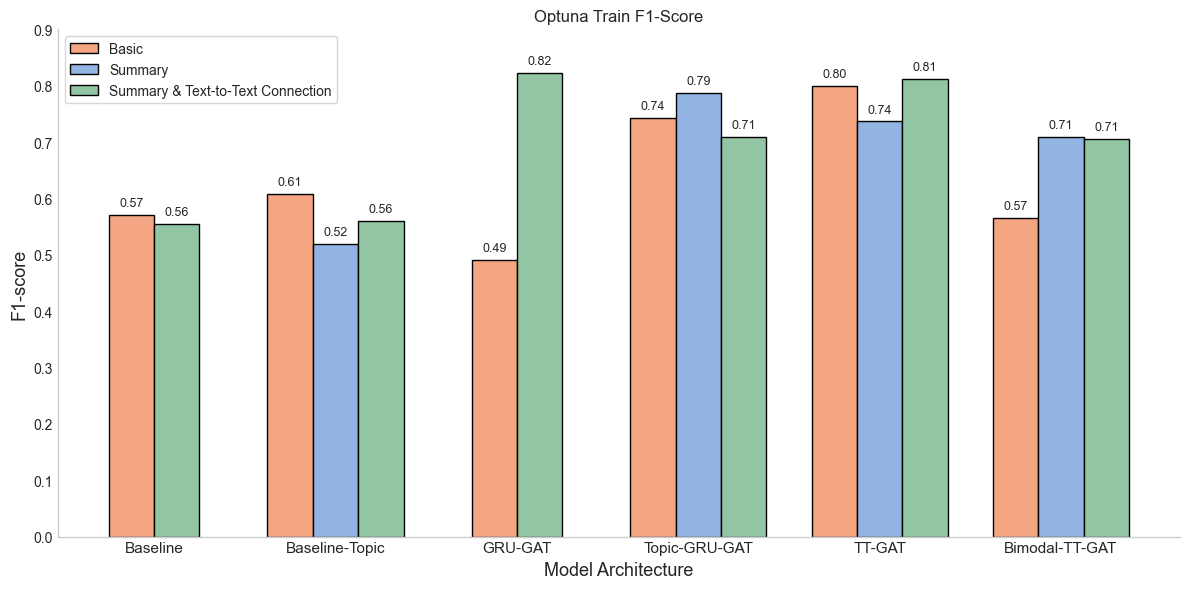

In [43]:
plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(f1_df))

colors = {
    "Basic": "#F4A582",
    "Summary & Text-to-Text Connection": "#92C5A3",
    "Summary": "#92B4E2"
}

for i, model in enumerate(f1_df.index):
  row = f1_df.loc[model]

  available_cols = row.dropna().index.tolist()
  n = len(available_cols)

  if n == 3:
    offsets = [-bar_width, 0, bar_width]
  elif n == 2:
    offsets = [-bar_width / 2, bar_width / 2]
  else:  # n == 1
    offsets = [0]

  for col, offset in zip(available_cols, offsets):
    value = row[col]

    bar = ax.bar(
      i + offset,
      value,
      bar_width,
      color=colors[col],
      edgecolor="black",
      label=col if i == 0 else None  # legend 중복 방지
    )

    ax.text(
      i + offset,
      value + 0.01,
      f"{value:.2f}",
      ha="center",
      va="bottom",
      fontsize=9
    )

legend_handles = [
  Patch(facecolor=colors[col], edgecolor="black", label=col)
  for col in f1_df.columns
]

ax.set_title('Optuna Train F1-Score')
ax.set_xticks(index)
ax.set_xticklabels(f1_df.index, fontsize=11)
ax.set_ylabel("F1-score", fontsize=13)
ax.set_xlabel("Model Architecture", fontsize=13)
ax.set_ylim(0, 0.9)

ax.legend(handles=legend_handles, frameon=True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.savefig(os.path.join(path_config.ROOT_DIR, 'graph_explanation', 'F1-score_result.png'), dpi=400)
plt.show()

In [42]:
params_df.to_csv(os.path.join(path_config.ROOT_DIR, 'graph_explanation', 'HPO_Hyperparams_result.csv'))
params_df_2.to_csv(os.path.join(path_config.ROOT_DIR, 'graph_explanation', 'HPO_Hyperparams_result2.csv'))